In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from pathlib import Path
import re
import time
import warnings

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.nddata import CCDData
import astroscrappy
import astroalign as aa
from ccdproc import combine
from matplotlib import pyplot as plt

plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14

In [3]:
# setting locations
DATADIR = Path('./data/reduc/2024-03-20')
RAWDIR = DATADIR / 'raw'
OUTDIR = DATADIR/ 'reduced'

# making output directory if it doesn't exist
if not OUTDIR.exists():
    OUTDIR.mkdir()

In [4]:
def make_summary_table(rawdir: Path):
    # making a summary table
    summary = []
    for f in rawdir.glob('*.fit'):
        hdr = fits.getheader(f)
        # getting the filter information
        # - SAO doesn't have a filter keyword, so we need to look at the filename
        # - checking for the filter in the filename with regex
        filt = 'unknown'
        if 'filter' in hdr:
            filt = hdr['filter']
        elif 'FILTER' in hdr:
            filt = hdr['FILTER']
        else:
            mtch = re.search(r'[UBVRIgriz].fit$', f.name)
            mtch_Ha = re.search(r'Ha.fit$', f.name)
            if mtch:
                filt = mtch.group(0)[0]
            elif mtch_Ha:
                filt = 'Ha'
            
        # getting the airmass X (Pickering 2002)
        try:
            alt = float(hdr['OBJCTALT'])
            X = 1/(np.sin(np.radians( alt + 244/(165 + 47*alt**1.1 ))))
        except TypeError:
            X = -1
        except Exception as e:
            print(f'Error in {f.name}: {e}')
            X = -1
        
        summary.append([f.name, hdr['DATE-OBS'], hdr['OBJECT'],
                        hdr['OBJCTRA'], hdr['OBJCTDEC'],
                        hdr['IMAGETYP'], hdr['EXPTIME'],
                        X, filt])
        stab = Table(rows=summary,
                     names=['filename', 'date-obs', 'object', 'ra', 'dec',
                            'imagetyp', 'exptime', 'airmass', 'filter'],
                     # str, str, str, float, float, str, float, float, str
                     dtype=['U50', 'U50', 'U50', 'U50', 'U50', 'U50', 'f8', 'f8', 'U50'])
    return stab

In [5]:
# making the summary table
summary_table = make_summary_table(RAWDIR)
# sorting the table by date
summary_table.sort('date-obs')
# showing the table
summary_table.show_in_notebook(display_length=5)

In [6]:
# table for each type of frame
bias_table = summary_table[summary_table['imagetyp'] == 'Bias Frame']
dark_table = summary_table[summary_table['imagetyp'] == 'Dark Frame']
flat_table = summary_table[summary_table['imagetyp'] == 'Flat Field']
sci_table = summary_table[summary_table['imagetyp'] == 'Light Frame']

# counting the number of frames
print(f'Number of bias frames: {len(bias_table)}')
print(f'Number of dark frames: {len(dark_table)}')
print(f'Number of flat frames: {len(flat_table)}')
print(f'Number of flat frames with g-band: {len(flat_table[flat_table["filter"] == "g"])}')
print(f'Number of science frames: {len(sci_table)}')
print(f'Number of science frames with g-band: {len(sci_table[sci_table["filter"] == "g"])}')

Number of bias frames: 5
Number of dark frames: 15
Number of flat frames: 28
Number of flat frames with g-band: 7
Number of science frames: 12
Number of science frames with g-band: 3


In [7]:
# test reading of science frame
fname = RAWDIR / sci_table['filename'][0]
hdu = fits.open(fname)
isci = 0
sci = hdu[isci].data   # 2D image array of pixel counts
hdr = hdu[isci].header # image header information

# simple visulization of the image
ibias, idark, iflat = 0, 0, 4
bias = fits.getdata(RAWDIR / bias_table['filename'][ibias])
dark = fits.getdata(RAWDIR / dark_table['filename'][idark])
flat = fits.getdata(RAWDIR / flat_table['filename'][iflat])

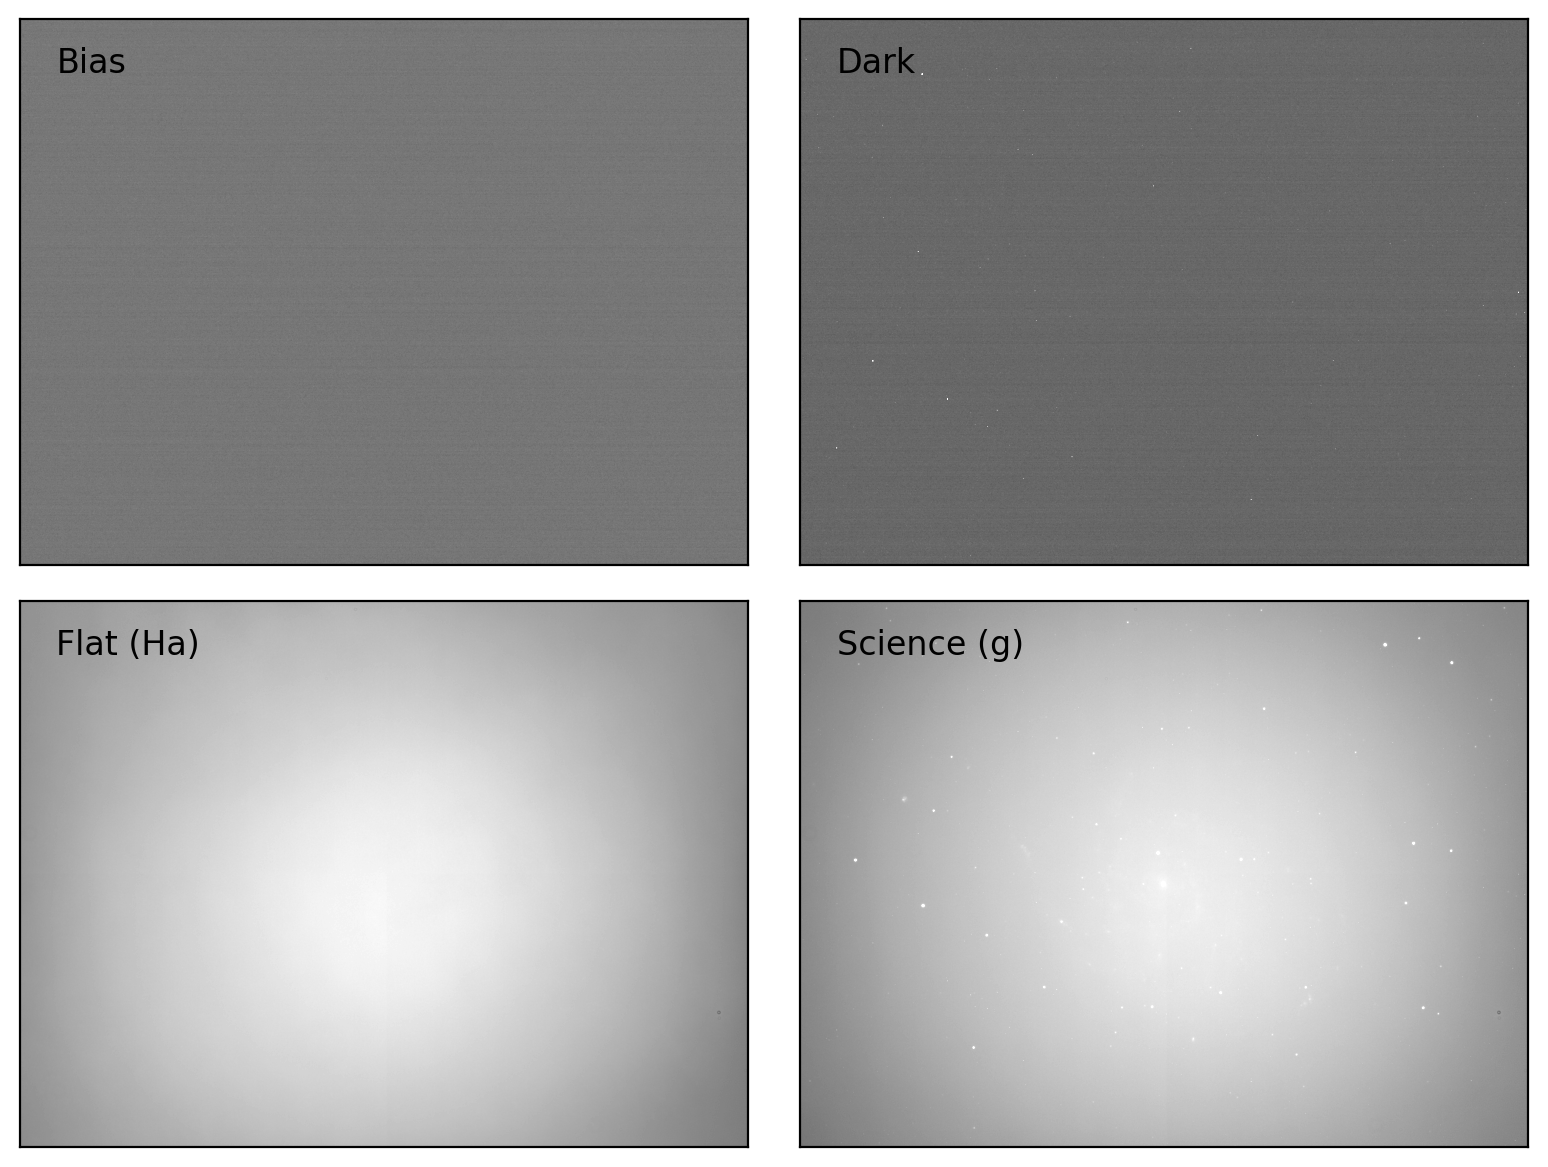

In [40]:
# for displaying in zscale
interval = ZScaleInterval()

# plotting the images
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
titles = ['Bias', 'Dark', f'Flat ({flat_table['filter'][iflat]})',
          f'Science ({sci_table['filter'][isci]})']
for i, img in enumerate([bias, dark, flat, sci]):
    vmin, vmax = interval.get_limits(img)
    ax = axes[i // 2][i % 2]
    ax.imshow(img, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax.text(0.05, 0.95, titles[i], transform=ax.transAxes, ha='left', va='top')
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
plt.tight_layout()

$$\sigma_{\rm ADU} = \frac{\rm Readout\ noise}{\rm Gain}$$

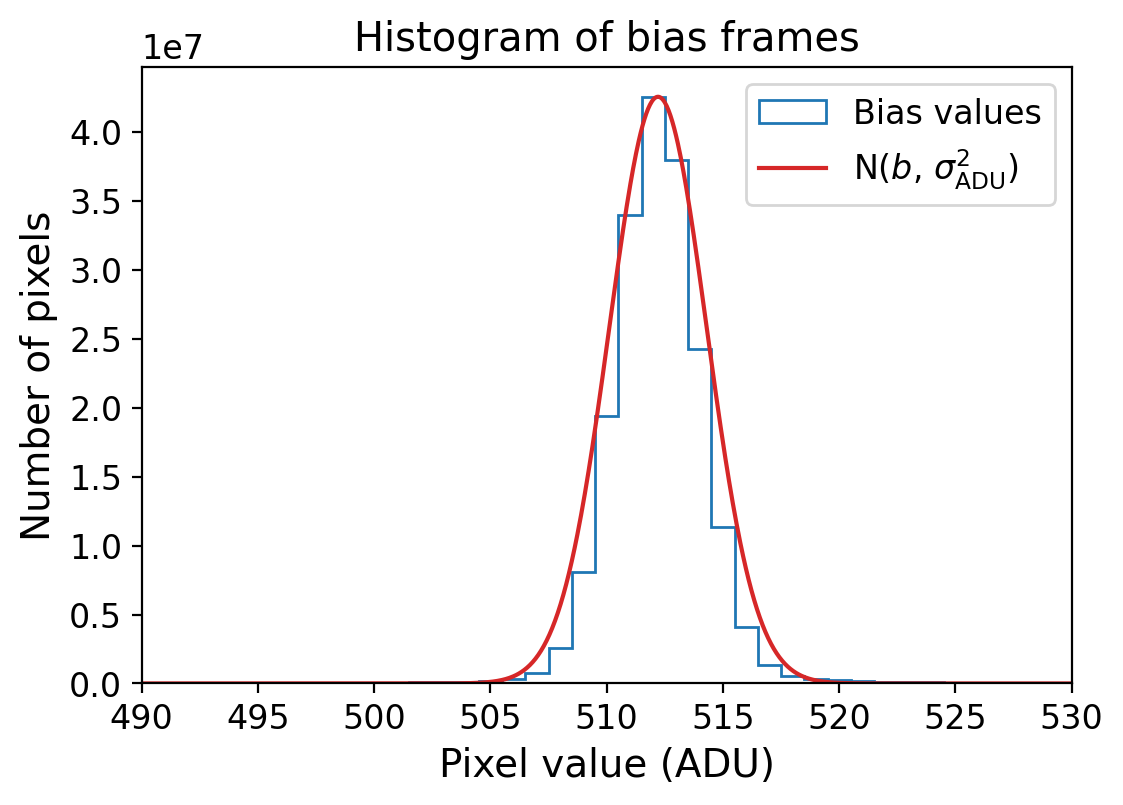

In [110]:
# get readout noise from bias frames
bias_imgs = np.array([fits.getdata(RAWDIR/f) for f in bias_table['filename']])

# bring gain
gain = fits.getheader(RAWDIR / bias_table['filename'][0])['EGAIN'] # e-/ADU

# calculate the readout noise
bias_level = np.mean(bias_imgs.ravel())
sig_adu = np.std(bias_imgs, ddof=1) # ADU
rdnoise = sig_adu * gain # e-

# plot the bias histogram
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
bins = np.arange(490, 530, 1)
y, _, _ = ax.hist(np.ravel(bias_imgs), bins=bins, histtype='step', align='left',
               label='Bias values')
# Gaussian model for comparison
x = np.linspace(490, 530, 1000)
gaussian = np.exp(-0.5 * ((x - bias_level) / sig_adu)**2) * np.max(y)
ax.plot(x, gaussian, c='tab:red', label=r'N($b$, $\sigma_{\rm ADU}^2$)')
ax.set_xlabel('Pixel value (ADU)')
ax.set_ylabel('Number of pixels')
ax.set_xlim(490, 530)
ax.set_title('Histogram of bias frames')
ax.legend()

[CCD Data Reduction Guide - 1.5. Image combination](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/01-06-Image-combination.html)

Time taken by median combine: 1.17 s
Time taken by sigma clipping combine: 8.33 s


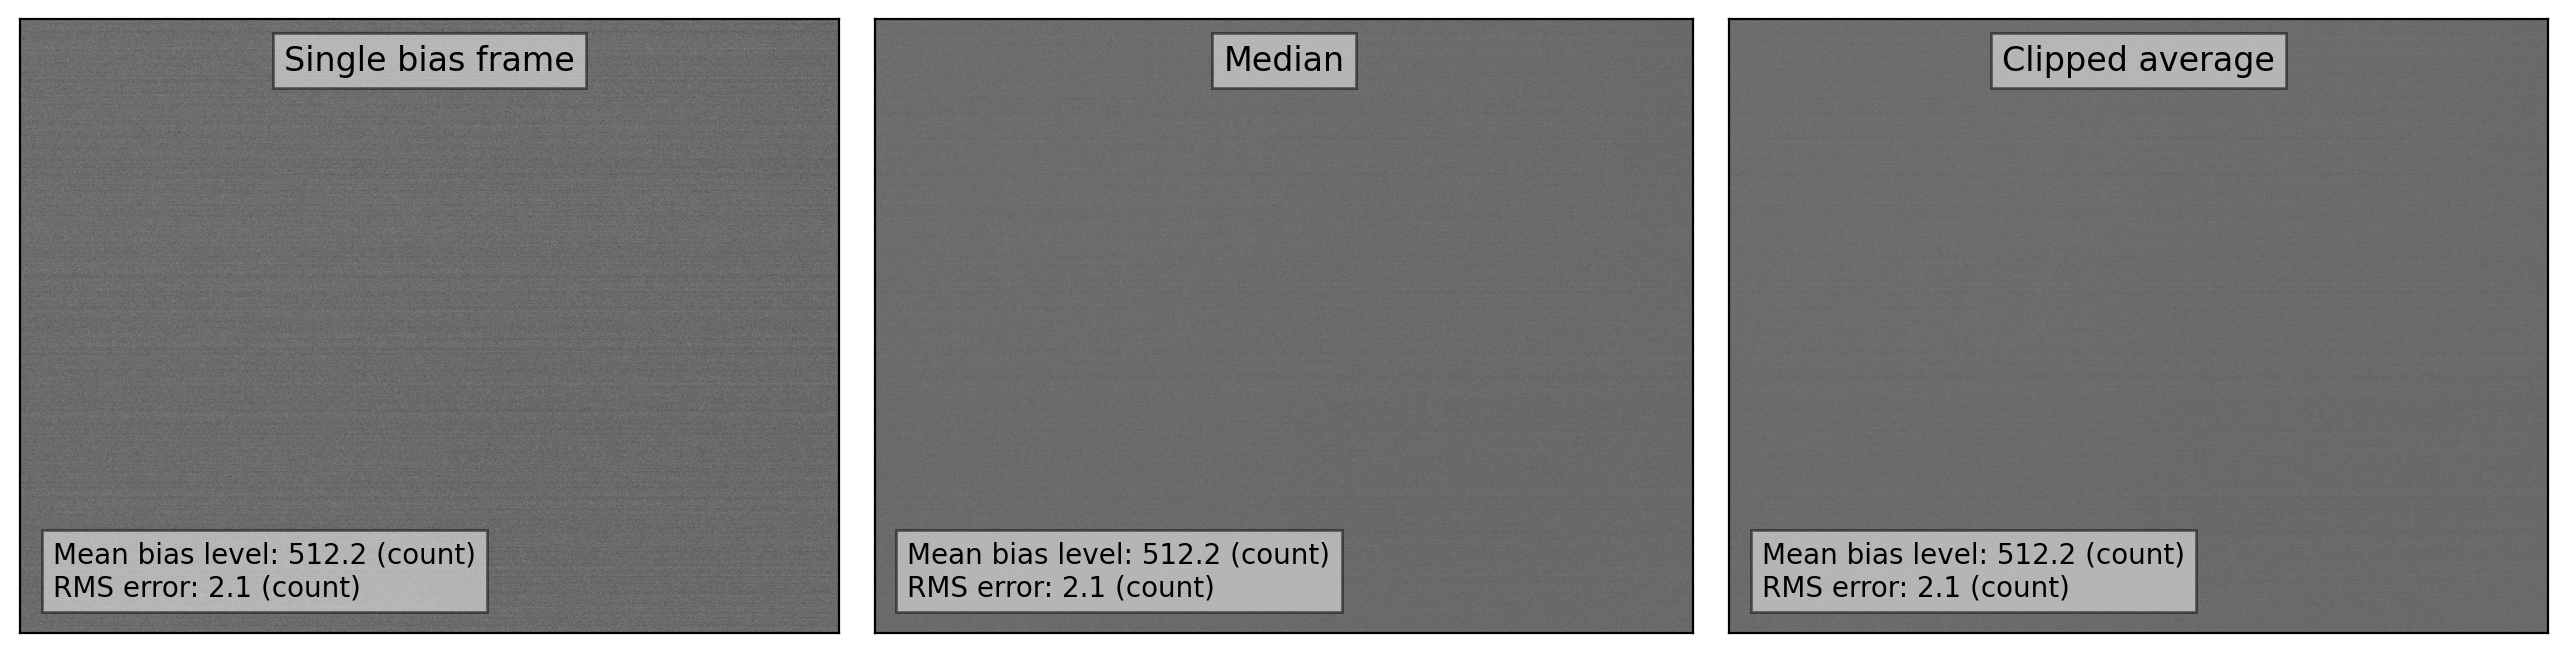

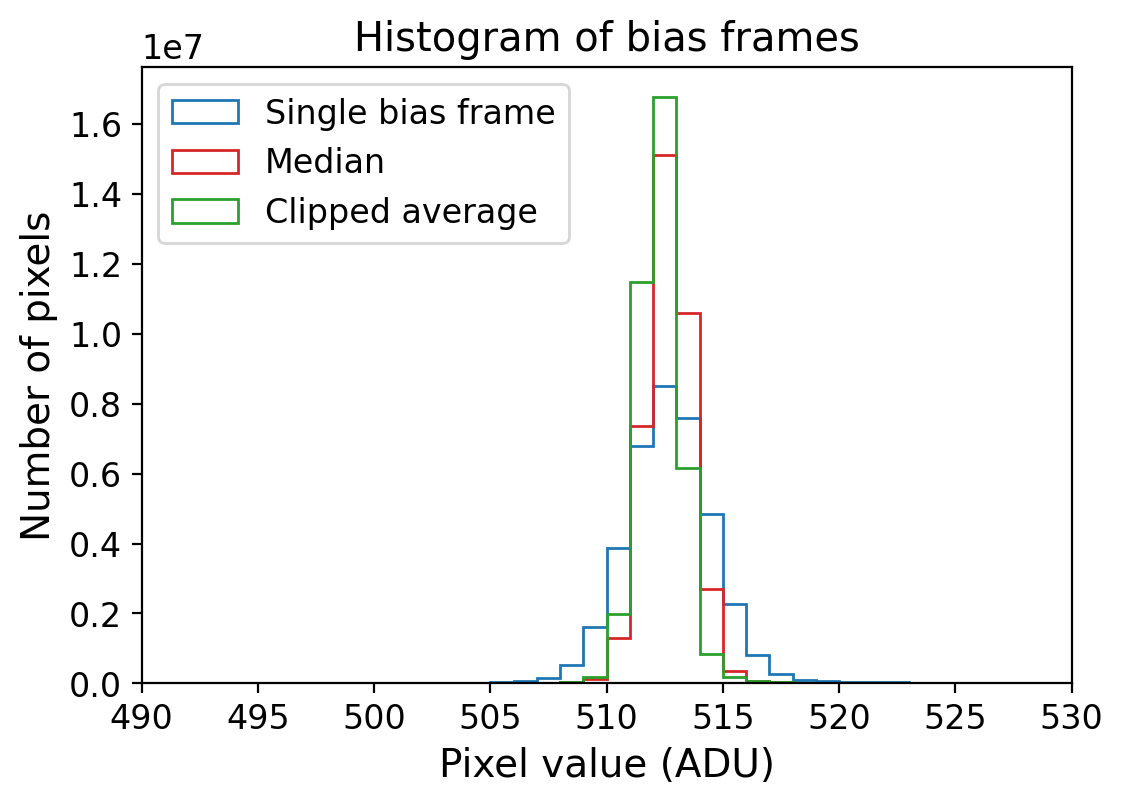

In [111]:
# create a master bias combining all bias frames
# median combine the bias frames
start = time.time()
medi_combine = np.median(bias_imgs, axis=0)
finish = time.time()
print(f'Time taken by median combine: {finish - start:.2f} s')

# combining bias frames with sigma clipping
# - stacking the empty array with bias frames (using CCDData)
bias_stack = []
for i in range(len(bias_table)):
    bias_data, bias_hdr = fits.getdata(RAWDIR/bias_table['filename'][i], header=True)
    bias = CCDData(data=bias_data, header=bias_hdr, unit='adu')
    bias_stack.append(bias)
# - combining
start = time.time()
clip_combine = combine(bias_stack, sigma_clip=True,
                       sigma_clip_high_thresh=3, sigma_clip_low_thresh=3)
finish = time.time()
print(f'Time taken by sigma clipping combine: {finish - start:.2f} s')

fig, axes = plt.subplots(1, 3, figsize=(13, 7))
vmin, vmax = interval.get_limits(medi_combine)
axes[0].imshow(bias_imgs[0], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[1].imshow(medi_combine, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[2].imshow(clip_combine, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[0].text(0.50, 0.96, 'Single bias frame',
             fontsize=12.0, bbox=dict(facecolor='white', alpha=0.5),
             transform=axes[0].transAxes, ha='center', va='top')
axes[1].text(0.50, 0.96, 'Median',
             fontsize=12.0, bbox=dict(facecolor='white', alpha=0.5),
             transform=axes[1].transAxes, ha='center', va='top')
axes[2].text(0.50, 0.96, 'Clipped average',
             fontsize=12.0, bbox=dict(facecolor='white', alpha=0.5),
             transform=axes[2].transAxes, ha='center', va='top')
axes[0].text(0.04, 0.15,
             f"Mean bias level: {np.mean(bias_imgs[0]):.1f} (count)"+
             f"\nRMS error: {np.std(bias_imgs[0]):.1f} (count)",
             fontsize=10.0, bbox=dict(facecolor='white', alpha=0.5),
             transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(0.04, 0.15,
             f"Mean bias level: {np.mean(medi_combine):.1f} (count)"+
             f"\nRMS error: {np.std(bias_imgs[0]):.1f} (count)",
             fontsize=10.0, bbox=dict(facecolor='white', alpha=0.5),
             transform=axes[1].transAxes, ha='left', va='top')
axes[2].text(0.04, 0.15,
             f"Mean bias level: {np.mean(clip_combine.data):.1f} (count)"+
             f"\nRMS error: {np.std(bias_imgs[0]):.1f} (count)",
             fontsize=10.0, bbox=dict(facecolor='white', alpha=0.5),
             transform=axes[2].transAxes, ha='left', va='top')
for ax in axes:
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
plt.tight_layout()
    
# bias histogram
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
bins = np.arange(490, 530, 1)
_ = ax.hist(np.ravel(bias_imgs[0]), bins=bins, histtype='step',
                     label='Single bias frame', color='tab:blue')
_ = ax.hist(np.ravel(medi_combine), bins=bins, histtype='step',
            label='Median', color='tab:red')
_ = ax.hist(np.ravel(clip_combine), bins=bins, histtype='step',
            label='Clipped average', color='tab:green')
ax.set_xlim(490, 530)
ax.set_xlabel('Pixel value (ADU)')
ax.set_ylabel('Number of pixels')
ax.set_title('Histogram of bias frames')
ax.legend()

# write the master bias to a fits file
mbias_file = OUTDIR / 'Mbias.fits'
bias_hdr = fits.getheader(RAWDIR / bias_table['filename'][0])
bias_hdr['RDNOISE'] = rdnoise # record the readout noise
bias_hdr['HISTORY'] = 'Master bias frame'
bias_hdr['HISTORY'] = f'Created on {time.asctime()}'
fits.writeto(mbias_file, clip_combine.data, bias_hdr, overwrite=True)

del bias_imgs, bias_stack, medi_combine, clip_combine


The level of the noises is slightly reduced by combining the images.
In this case, we only combined five bias frames. However, for more serious data
reduction, combining typically more than 10 bias frames is recommended to
reduce the noise of the bias level further.

In [92]:
# - Note that the dark frames might have different exposure times.
def make_mdark(dark_list, mbias=None, verbose=True, plot=False):
    # - checking the basic info
    # - Please check the consistancy in observation dates and exposure times.
    if verbose:
        for i in np.arange(len(dark_list)):
                dark_hdr = fits.getheader(dark_list[i])
                print(f"\nDark frame {i+1:d}")
                for keys in ['DATE-OBS', 'EXPTIME']:
                        print("  "+keys+" = "+str(dark_hdr[keys]))
    
    # - stacking dark frames
    dark_stack = []
    start = time.time()
    for i in range(len(dark_list)):
        dark_data, dark_hdr = fits.getdata(dark_list[i], header=True)
        if mbias is None:
                dark_bn = dark_data
        else:
                dark_bn = (dark_data - mbias.data)# / dark_hdr['EXPTIME']
        dark = CCDData(data=dark_bn, header=dark_hdr, unit='adu')    
        dark_stack.append(dark)
    finish = time.time()
    print(f"\nReading {len(dark_list)} dark frames took {finish-start:.2f} sec")
        
    # - combine with sigma clipping
    start = time.time()
    mdark = combine(dark_stack, sigma_clip=True,
                    sigma_clip_high_thresh=3, sigma_clip_low_thresh=3)
    finish = time.time()
    print(f"Combining {len(dark_list)} dark frames took {finish-start:.2f} sec")
    
    # - correcting the negative values
    mdark.data[mdark.data < 0.] = 0.
    
    # - save the master dark as fits file
    start = time.time()
    dark_hdr['NFRAMES'] = len(dark_list)  # recording # of dark frames combined
    fits.writeto(OUTDIR/f"MDark{dark_hdr['EXPTIME']:.0f}.fits",
                 mdark, dark_hdr, overwrite=True)
    finish = time.time()
    print(f"Writing the master dark took {finish-start:.2f} sec")
    
    if plot:
        # - visualization of the master dark
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
        vmin, vmax = interval.get_limits(mdark)
        ax.imshow(mdark, origin='lower', vmin=vmin, vmax=vmax, cmap='gray')
        ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
        ax.text(0.50, 0.96, "Master Dark\n(sc combined, bias-subtracted)",
                fontsize=12.0, bbox=dict(facecolor='white', alpha=0.5),
                transform=ax.transAxes, ha='center', va='top')
        ax.text(0.04, 0.15, f"Exposure time: {dark_hdr['EXPTIME']:.1f} (count)"+
                f"\nMean dark level: {np.mean(mdark.data):.1f} (count)",
                fontsize=10.0, bbox=dict(facecolor='white', alpha=0.5),
                transform=ax.transAxes, ha='left', va='top')
        plt.tight_layout()
    
    return mdark


Reading 5 dark frames took 0.98 sec
Combining 5 dark frames took 12.78 sec
Writing the master dark took 0.14 sec


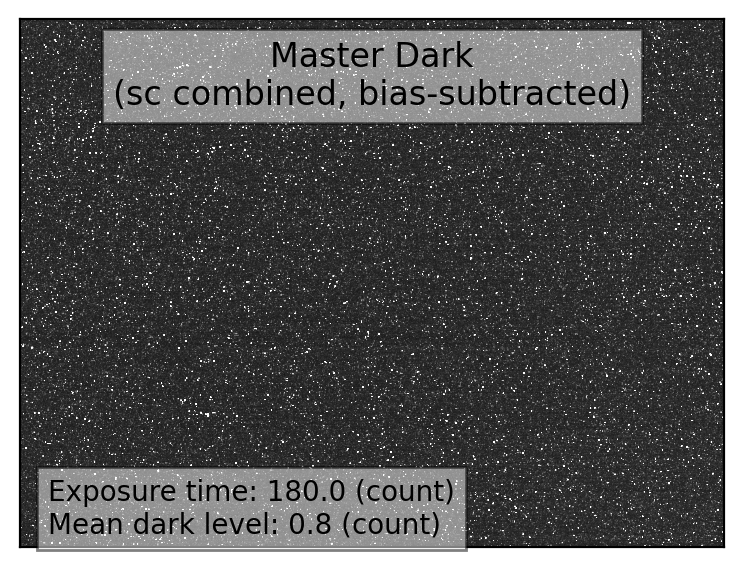

In [96]:
_ = make_mdark(fnames, mbias, verbose=False, plot=True)

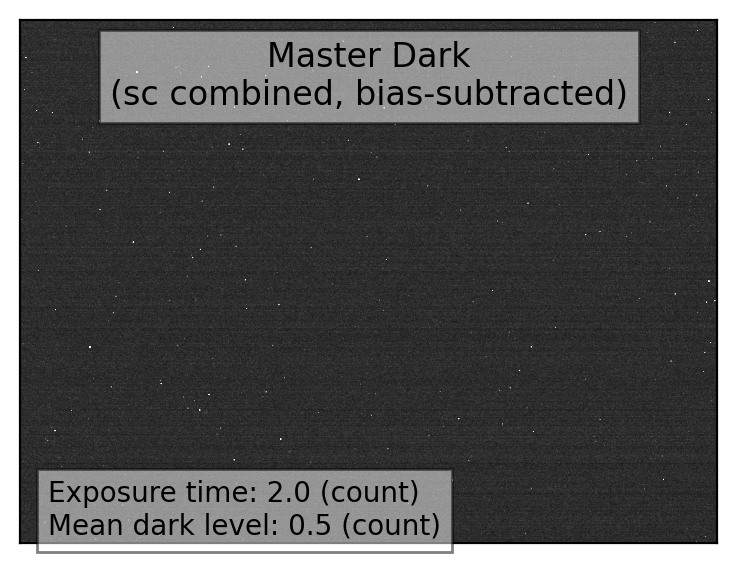

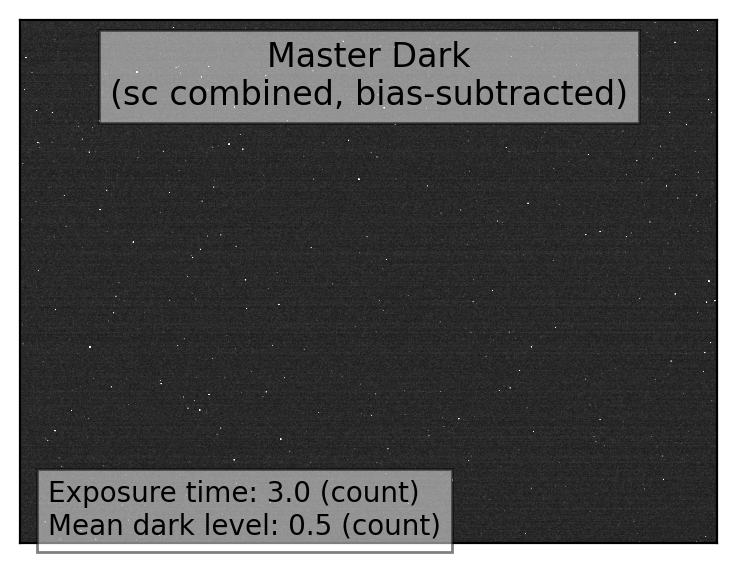

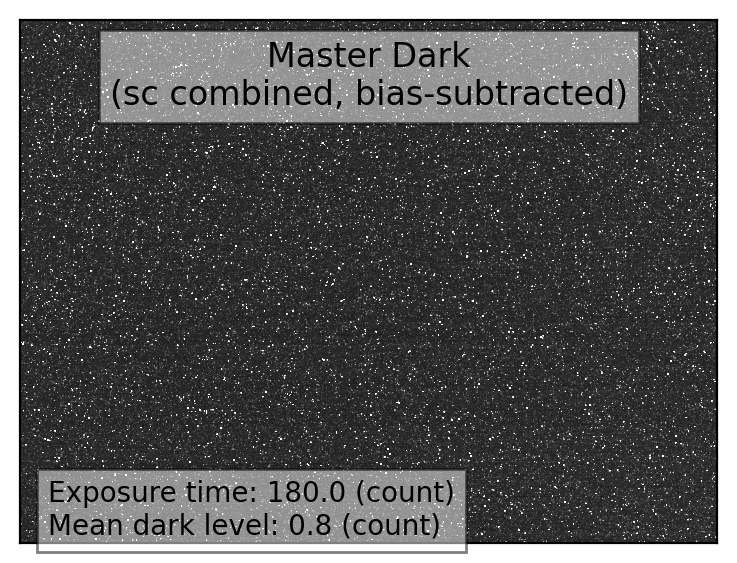

In [85]:
mbias = fits.getdata(mbias_file) # read the master bias
for group in dark_table.group_by('exptime').groups: # group by exposure time
    fnames = [RAWDIR/f for f in group['filename']] #
    _ = make_mdark(fnames, mbias, verbose=False, plot=True)